In [1]:
from keras.layers import *
from keras.datasets import mnist
from keras.models import Model
import matplotlib.pyplot as plt

/usr/local/lib/python2.7/dist-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


tf.estimator package not installed.
tf.estimator package not installed.


In [2]:
from IPython.core.pylabtools import figsize
figsize(14, 7)

plt.rcParams.update({'font.size': 22})

In [3]:
(x_train, y_train), (x_test,y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))  # adapt this if using `channels_first` image data format
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))

# Encoder

In [4]:
input_img = Input(shape=(28, 28, 1))  # adapt this if using `channels_first` image data format

x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = Flatten()(x)
encoder_output = Dense(2)(x)

In [5]:
encoder = Model(inputs=input_img, outputs=encoder_output)
encoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 16)        160       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 8)         1160      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 7, 8)           0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 7, 7, 8)           584       
_________________________________________________________________
flatten_1 (Flatten)          (None, 392)               0         
__________

# Decoder

In [6]:
decoder_input = Input((2,))
x = Dense(128, activation='relu')(decoder_input)
x = Reshape((4,4,8))(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu')(x)
x = UpSampling2D((2, 2))(x)
decoder_output = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)
decoder = Model(inputs=decoder_input, outputs=decoder_output)

In [7]:
decoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 2)                 0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               384       
_________________________________________________________________
reshape_1 (Reshape)          (None, 4, 4, 8)           0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 4, 4, 8)           584       
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 8, 8, 8)           0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 8, 8, 8)           584       
_________________________________________________________________
up_sampling2d_2 (UpSampling2 (None, 16, 16, 8)         0         
__________

In [8]:
autoencoder = Model(inputs=input_img, outputs=decoder(encoder_output))
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

In [9]:
history = autoencoder.fit(
    x_train, x_train,
    epochs=25,
    batch_size=128,
    shuffle=True,
    verbose=0,
    validation_data=(x_test, x_test)
)

# Visuals

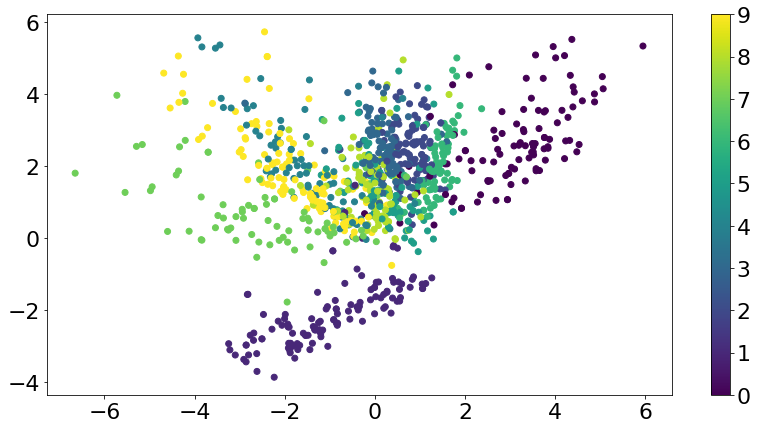

In [10]:
encoded_points = encoder.predict(x_test)

idx = np.random.choice(np.arange(x_test.shape[0]), 1000)

x = encoded_points[idx, 0]
y = encoded_points[idx, 1]
c = y_test[idx]

plt.scatter(x, y, c=c)
plt.colorbar()

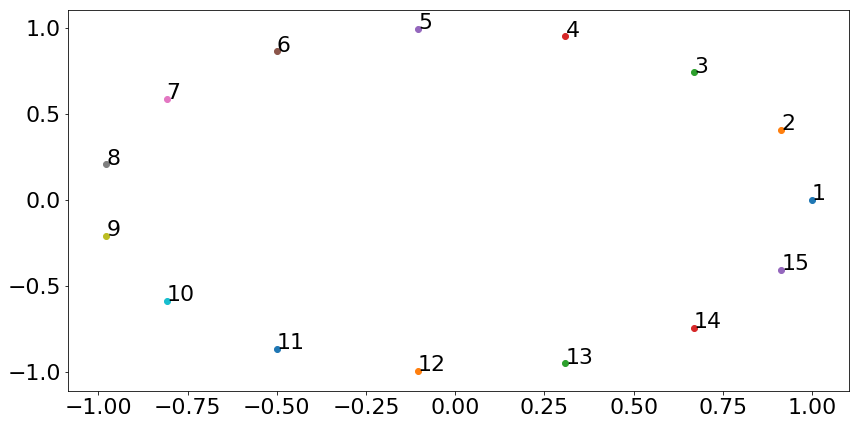

In [11]:
radians = np.linspace(0,2*np.pi, 15, endpoint=False)
x = np.cos(radians)
y = np.sin(radians)

for i,point in enumerate(zip(x,y)):
    plt.text(
        x=point[0], 
        y=point[1],
        s=str(i+1)
    )
    plt.scatter(point[0], point[1])

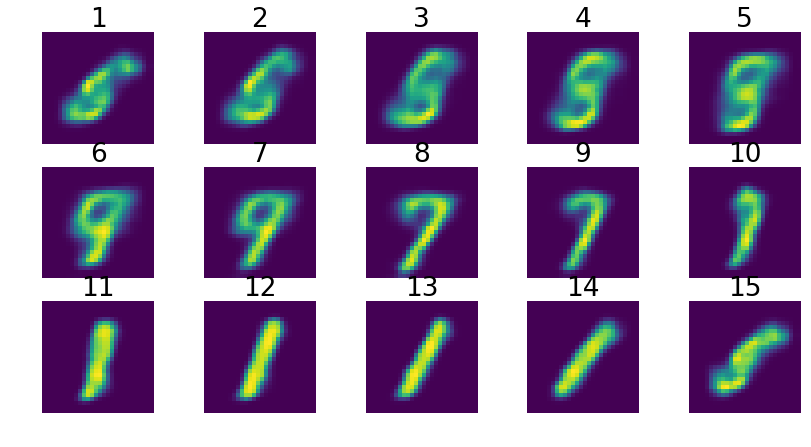

In [12]:
for i in range(1,16):
    
    img = decoder.predict(np.array([
        [x[i-1],y[i-1]]
    ]))
    
    plt.subplot(3,5,i)
    plt.imshow(img.squeeze()); plt.axis('off'); plt.title(str(i))
    
plt.show()